In [52]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
#pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import statsmodels.api as sm
import seaborn as sb
from sklearn.linear_model import Perceptron, LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import normaltest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

### We import the data, which has been pre-processed into two sets. One contains the difference in price over the last 60 minutes, and the other contains the prices from the last 60 minutes, sampled at ten second intervals. Each dataframe also contains a feature called "Direction" which indicates whether or not the most current price is up, down, or unchanged from the second to last price - this can be used for classification.  

In [3]:
#read hdfs and make index the date
df_diff = pd.read_hdf('store_nb.h5', 'diff')

df_lag = pd.read_hdf('store_nb.h5', 'lag')


In [4]:
df_lag.head()

,price,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag352,Lag353,Lag354,Lag355,Lag356,Lag357,Lag358,Lag359,Lag360,Direction
date,,,,,,,,,,,,,,,,,,,,,
2016-03-01 01:00:00,437.456667,437.430000,437.430000,437.430000,437.375000,437.375,437.375,437.332,437.332,437.332,...,436.46375,436.46375,436.46375,436.405625,436.405625,436.405625,436.314118,436.314118,436.314118,1.0
2016-03-01 01:00:10,437.456667,437.456667,437.430000,437.430000,437.430000,437.375,437.375,437.375,437.332,437.332,...,436.48000,436.46375,436.46375,436.463750,436.405625,436.405625,436.405625,436.314118,436.314118,0.0
2016-03-01 01:00:20,437.456667,437.456667,437.456667,437.430000,437.430000,437.430,437.375,437.375,437.375,437.332,...,436.48000,436.48000,436.46375,436.463750,436.463750,436.405625,436.405625,436.405625,436.314118,0.0
2016-03-01 01:00:30,437.440000,437.456667,437.456667,437.456667,437.430000,437.430,437.430,437.375,437.375,437.375,...,436.48000,436.48000,436.48000,436.463750,436.463750,436.463750,436.405625,436.405625,436.405625,-1.0
2016-03-01 01:00:40,437.384444,437.440000,437.456667,437.456667,437.456667,437.430,437.430,437.430,437.375,437.375,...,436.48200,436.48000,436.48000,436.480000,436.463750,436.463750,436.463750,436.405625,436.405625,-1.0


In [5]:
df_diff.head()

,price_delta,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag352,Lag353,Lag354,Lag355,Lag356,Lag357,Lag358,Lag359,Lag360,Direction
date,,,,,,,,,,,,,,,,,,,,,
2016-03-01 01:00:10,0.000000,0.026667,0.000000,0.000000,0.055000,0.000000,0.000,0.043,0.000,0.000,...,0.01625,0.00000,0.00000,0.058125,0.000000,0.000000,0.091507,0.000000,0.000000,0.0
2016-03-01 01:00:20,0.000000,0.000000,0.026667,0.000000,0.000000,0.055000,0.000,0.000,0.043,0.000,...,0.00000,0.01625,0.00000,0.000000,0.058125,0.000000,0.000000,0.091507,0.000000,0.0
2016-03-01 01:00:30,-0.016667,0.000000,0.000000,0.026667,0.000000,0.000000,0.055,0.000,0.000,0.043,...,0.00000,0.00000,0.01625,0.000000,0.000000,0.058125,0.000000,0.000000,0.091507,-1.0
2016-03-01 01:00:40,-0.055556,-0.016667,0.000000,0.000000,0.026667,0.000000,0.000,0.055,0.000,0.000,...,0.00200,0.00000,0.00000,0.016250,0.000000,0.000000,0.058125,0.000000,0.000000,-1.0
2016-03-01 01:00:50,0.000000,-0.055556,-0.016667,0.000000,0.000000,0.026667,0.000,0.000,0.055,0.000,...,0.00000,0.00200,0.00000,0.000000,0.016250,0.000000,0.000000,0.058125,0.000000,0.0


### First we will examine the lagged price data:

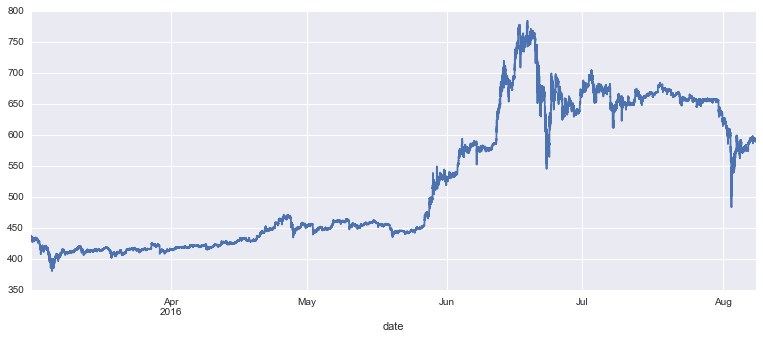

In [6]:
df_lag.price.plot(figsize=(13, 5))

In [7]:
#check the autocorrelations - very high
print df_lag['price'].autocorr(lag=1)

0.99999793864


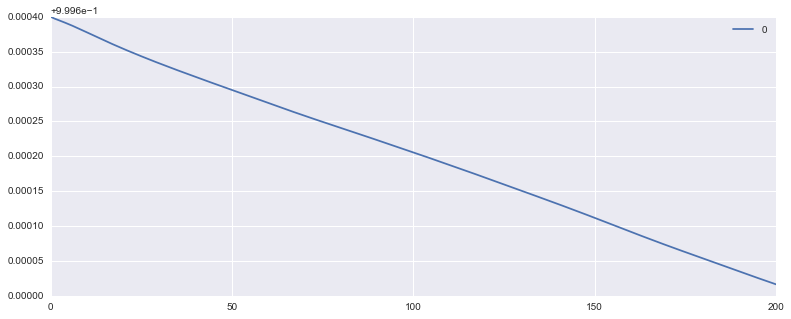

In [8]:
from statsmodels.tsa.stattools import acf
pd.DataFrame(acf(df_lag.price, nlags=200, fft=True)).plot(figsize=(13, 5))

In [9]:
print normaltest(df_lag.price) # cannot conclude normality, but this is ok for linear regression..

NormaltestResult(statistic=masked, pvalue=1.0)


### Now we will divide the lagged data into training and test sets so that we can run models

In [10]:
y_c = df_lag['Direction'] # for classification
#exog and endog
X = df_lag.drop("Direction", axis = 1)
X = X.drop('price', axis = 1)
y = df_lag['price'] # for regression 


# The test data is split into two parts
start_test = datetime.datetime(2016,6,1)

# Create training and test sets
X_train = X[X.index < start_test]
X_test = X[X.index >= start_test]
y_train = y[y.index < start_test]
y_test = y[y.index >= start_test]
y_c_train = y_c[y_c.index < start_test]
y_c_test = y_c[y_c.index >= start_test]

### Fit a linear regression and evaluate the performance:

In [11]:
lin = LinearRegression(n_jobs = 3)
lin.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

#### Plot the residuals: the difference in the test and training resididuals reflects the volatility in price towards the end of data - using a larger window may ease this.  The test residuals in particular look nicely distributed.

In [12]:
lin_p = lin.predict(X_test)
lin_p_train = lin.predict(X_train)

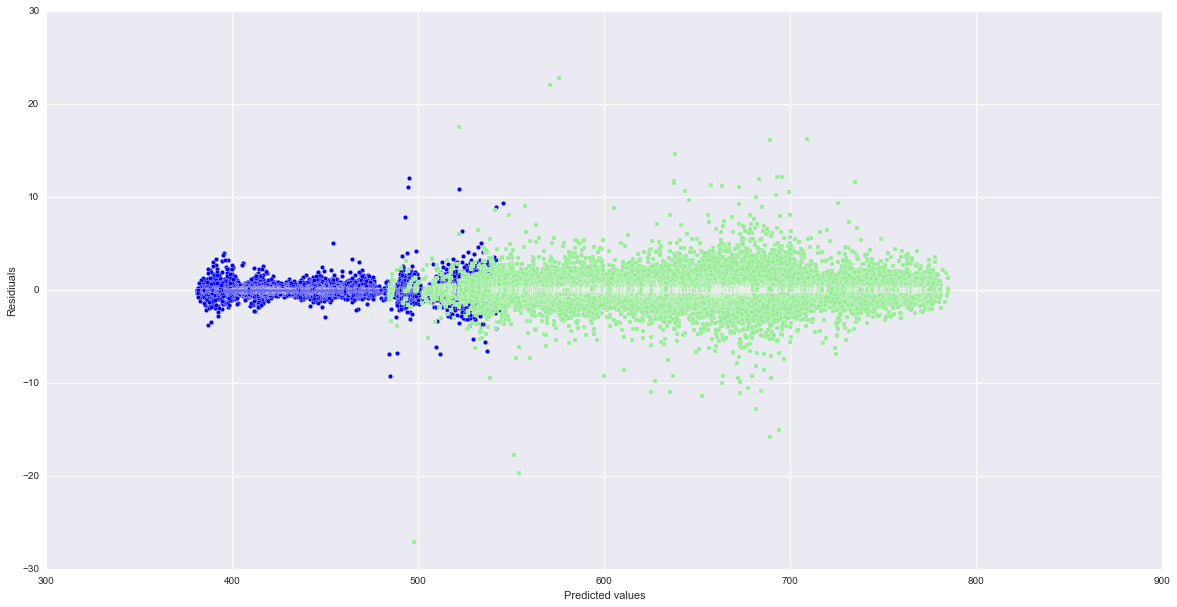

In [13]:
plt.figure(figsize=(20,10))
plt.scatter(lin_p_train, lin_p_train - y_train, c = 'blue', marker = 'o', label = 'Training Data')
plt.scatter(lin_p, lin_p - y_test, c = 'lightgreen', marker = 's', label = 'Test Data')
plt.xlabel('Predicted values')
plt.ylabel('Residiuals')
plt.show()

#### Check the key metrics on the training set

In [14]:
print metrics.mean_absolute_error(y_train, lin_p_train)
print metrics.mean_squared_error(y_train, lin_p_train)
print metrics.explained_variance_score(y_train, lin_p_train)
print metrics.r2_score(y_train, lin_p_train)

0.0322136337416
0.0108548081104
0.999983946579
0.999983946579


#### Check the key metrics on the test set: not too bad. We may be overfitting on the training set a little. 

In [15]:
print metrics.mean_absolute_error(y_test, lin_p)
print metrics.mean_squared_error(y_test, lin_p)
print metrics.explained_variance_score(y_test, lin_p)
print metrics.r2_score(y_test, lin_p)

0.102411333923
0.102148984094
0.999961623743
0.999961623575


#### Graph the predicted versus the actual data: it fits very closely, so we have to zoom into the hour timeframe to see this. 

In [16]:
lin_predicted = pd.Series(lin_p, index = y_test.index)
lin_actuals = pd.Series(y_test)

df_plot = pd.DataFrame()
df_plot['lin_actuals'] = lin_actuals
df_plot['lin_predicted'] = lin_predicted

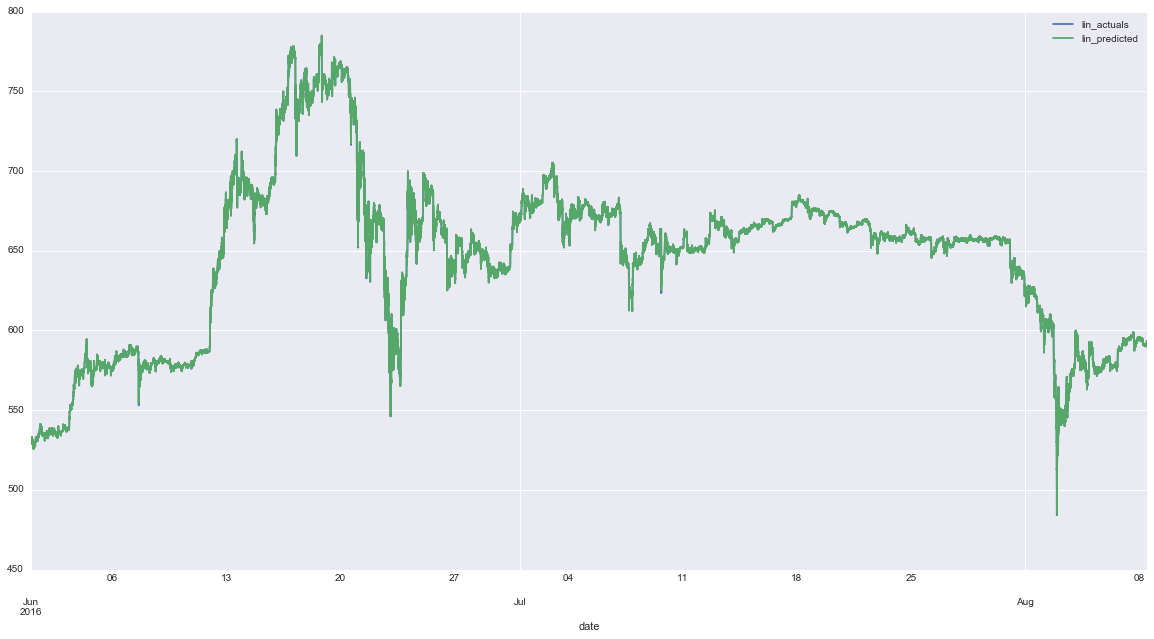

In [17]:
df_plot.plot(figsize=(20, 10))

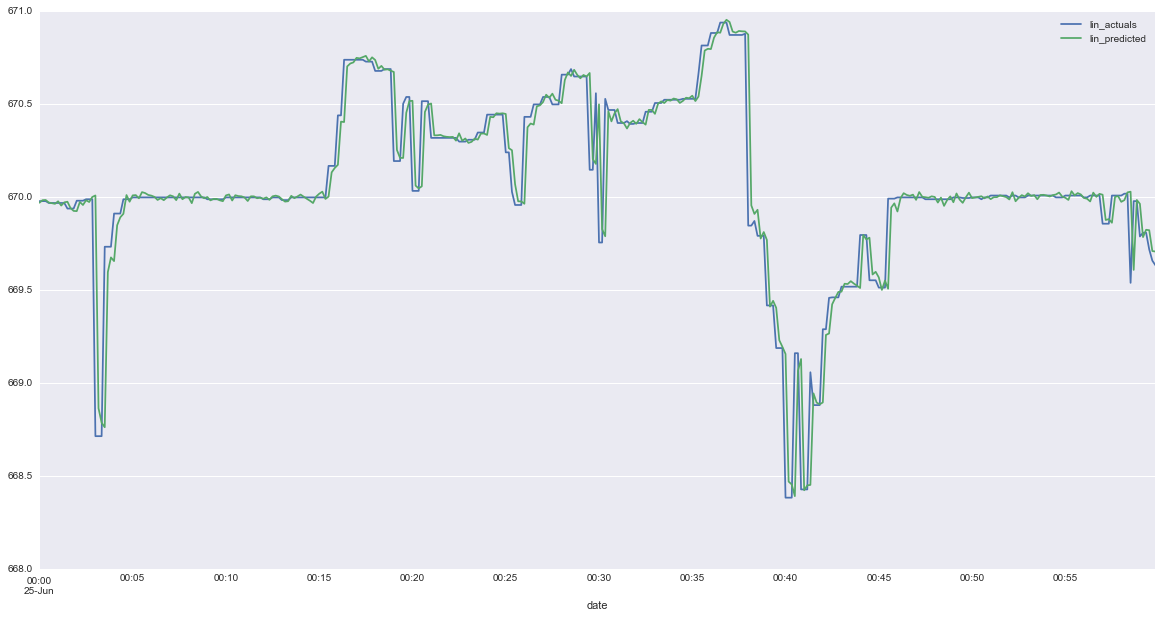

In [18]:
df_plot.loc[(df_plot.index.year==2016)&(df_plot.index.month==6)\
            &(df_plot.index.day==25)&(df_plot.index.hour==0)].plot(figsize=(20, 10))

### Now we will take a look at the differenced data, and see if there might be any differences. This is now the price change from the last ten second period, as opposed to the prices themselves sampled every ten seconds. 

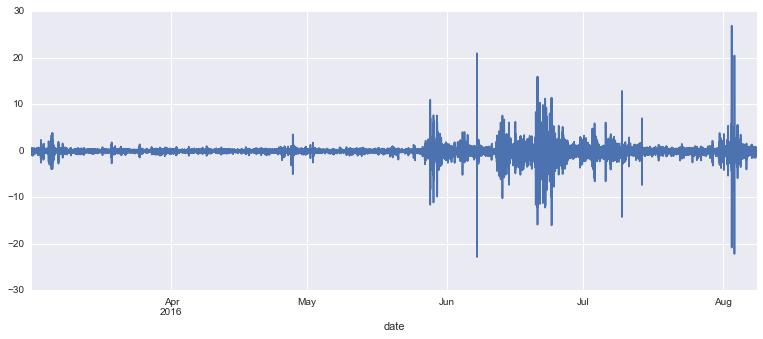

In [19]:
#plot the differenced data
df_diff.price_delta.plot(figsize=(13, 5))

In [20]:
# check the autocorrelation - much less than the actual prices
print df_diff['price_delta'].autocorr(lag=1)

-0.100338612224


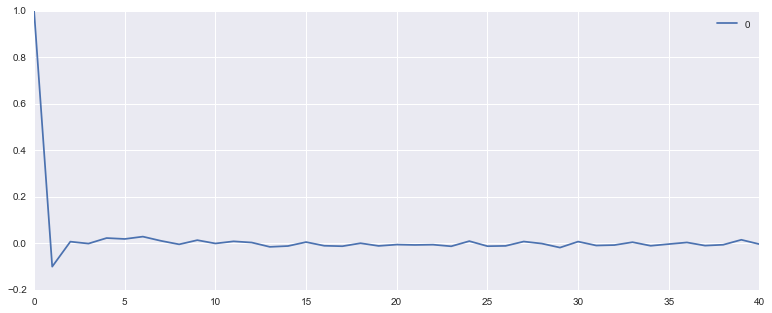

In [21]:
pd.DataFrame(acf(df_diff.price_delta, nlags=40, fft=True)).plot(figsize=(13, 5))

### Now we will divide the difference data into training and test sets so that we can run models

In [22]:
y_c = df_diff['Direction'] # for classification
#exog and endog
X = df_diff.drop("Direction", axis = 1)
X = X.drop('price_delta', axis = 1)
y = df_diff['price_delta'] # for regression 


# The test data is split into two parts
start_test = datetime.datetime(2016,7,1)

# Create training and test sets
X_train = X[X.index < start_test]
X_test = X[X.index >= start_test]
y_train = y[y.index < start_test]
y_test = y[y.index >= start_test]
y_c_train = y_c[y_c.index < start_test]
y_c_test = y_c[y_c.index >= start_test]

### Fit a linear regression and evaluate the performance:

In [23]:
lin = LinearRegression(n_jobs = 3)
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

#### Plot the residuals:

In [24]:
lin_p = lin.predict(X_test)
lin_p_train = lin.predict(X_train)

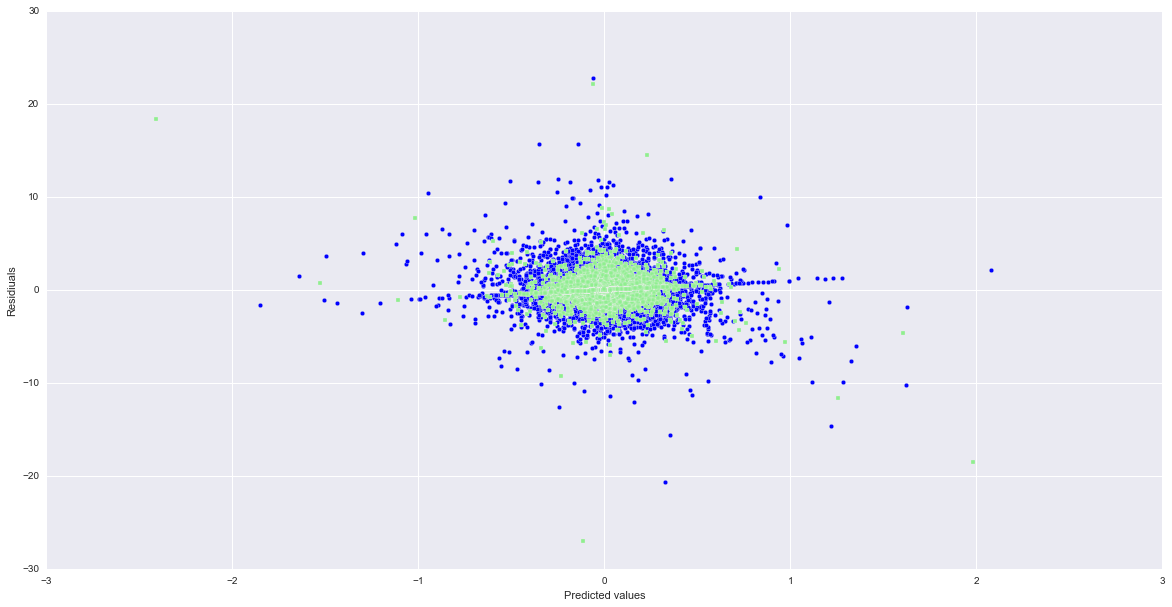

In [25]:
plt.figure(figsize=(20,10))
plt.scatter(lin_p_train, lin_p_train - y_train, c = 'blue', marker = 'o', label = 'Training Data')
plt.scatter(lin_p, lin_p - y_test, c = 'lightgreen', marker = 's', label = 'Test Data')
plt.xlabel('Predicted values')
plt.ylabel('Residiuals')
plt.show()

#### Check the key metrics on the training set: The r-squared is now terrible. 

In [26]:
print metrics.mean_absolute_error(y_train, lin_p_train)
print metrics.mean_squared_error(y_train, lin_p_train)
print metrics.explained_variance_score(y_train, lin_p_train)
print metrics.r2_score(y_train, lin_p_train)

0.0573307020734
0.0499488663958
0.0195493697384
0.0195493697384


#### Check the key metrics on the test set: Are we overfitting, or perhaps underfitting because we are no longer tracking variance very closely

In [27]:
print metrics.mean_absolute_error(y_test, lin_p)
print metrics.mean_squared_error(y_test, lin_p)
print metrics.explained_variance_score(y_test, lin_p)
print metrics.r2_score(y_test, lin_p)

0.0693819316278
0.0463181250333
0.0128917655059
0.0128853516054


#### Graph the predicted versus the actual data: it no longer fits very closely and does not track the volatility well at all. 

In [28]:
lin_predicted = pd.Series(lin_p, index = y_test.index)
lin_actuals = pd.Series(y_test)

df_plot = pd.DataFrame()
df_plot['lin_actuals'] = lin_actuals
df_plot['lin_predicted'] = lin_predicted

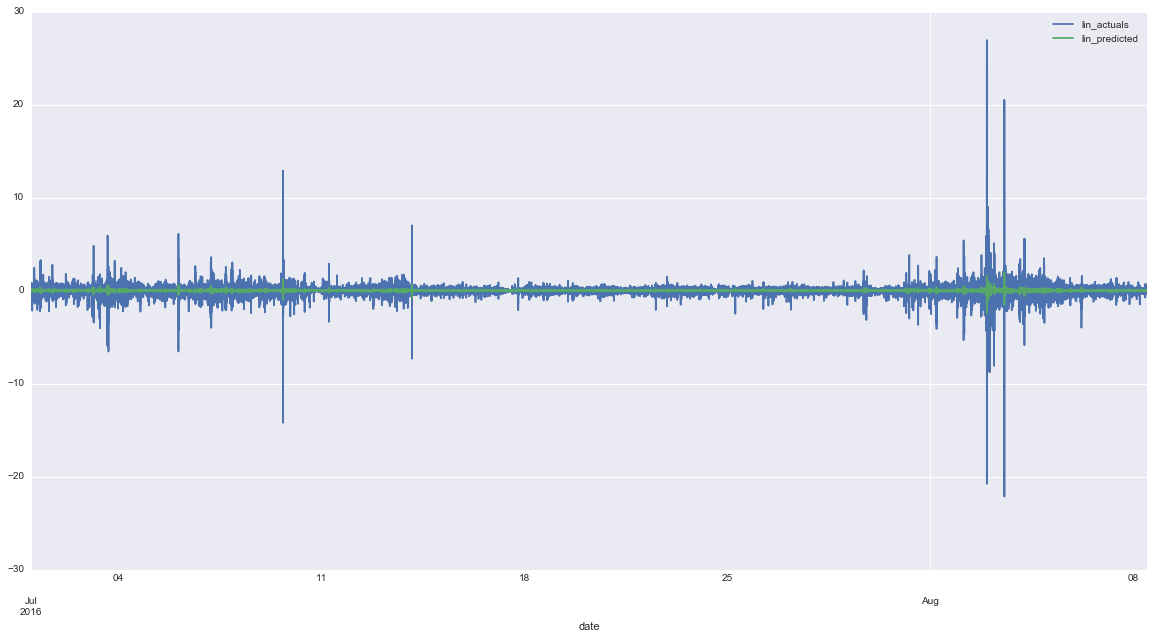

In [29]:
df_plot.plot(figsize=(20, 10))

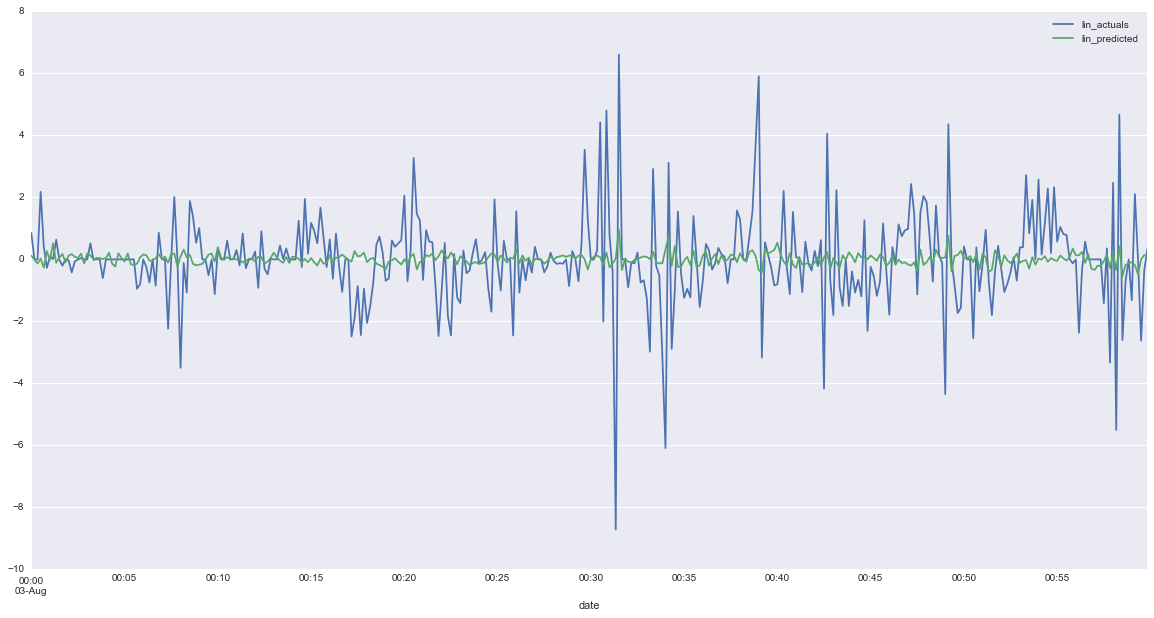

In [30]:
df_plot.loc[(df_plot.index.year==2016)&(df_plot.index.month==8)\
            &(df_plot.index.day==3)&(df_plot.index.hour==0)].plot(figsize=(20, 10))

#### We can actually now transform our regression into a classification and test how it performed on predicting the up and down movements

In [31]:
# now check class error by transforming
def class_transform(df):
    df2 = pd.DataFrame(df)
    df2["Direction_act"] = np.sign(df2["lin_actuals"])
    df2["Direction_pred"] = np.sign(df2["lin_predicted"])
    return df2

In [32]:
df_reg2class = class_transform(df_plot)

In [33]:
df_reg2class.head()

,lin_actuals,lin_predicted,Direction_act,Direction_pred
date,,,,
2016-07-01 00:00:00,0.01,0.005221,1.0,1.0
2016-07-01 00:00:10,0.00,0.000279,0.0,1.0
2016-07-01 00:00:20,0.00,0.002123,0.0,1.0
2016-07-01 00:00:30,0.00,-0.005415,0.0,-1.0
2016-07-01 00:00:40,0.00,0.002117,0.0,1.0


In [34]:
print metrics.classification_report(df_reg2class.Direction_act,\
                                    df_reg2class.Direction_pred)
print metrics.accuracy_score(df_reg2class.Direction_act,\
                                    df_reg2class.Direction_pred)

             precision    recall  f1-score   support

       -1.0       0.14      0.51      0.22     45934
        0.0       0.00      0.00      0.00    232674
        1.0       0.16      0.51      0.25     54033

avg / total       0.05      0.15      0.07    332641

0.152771306003


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


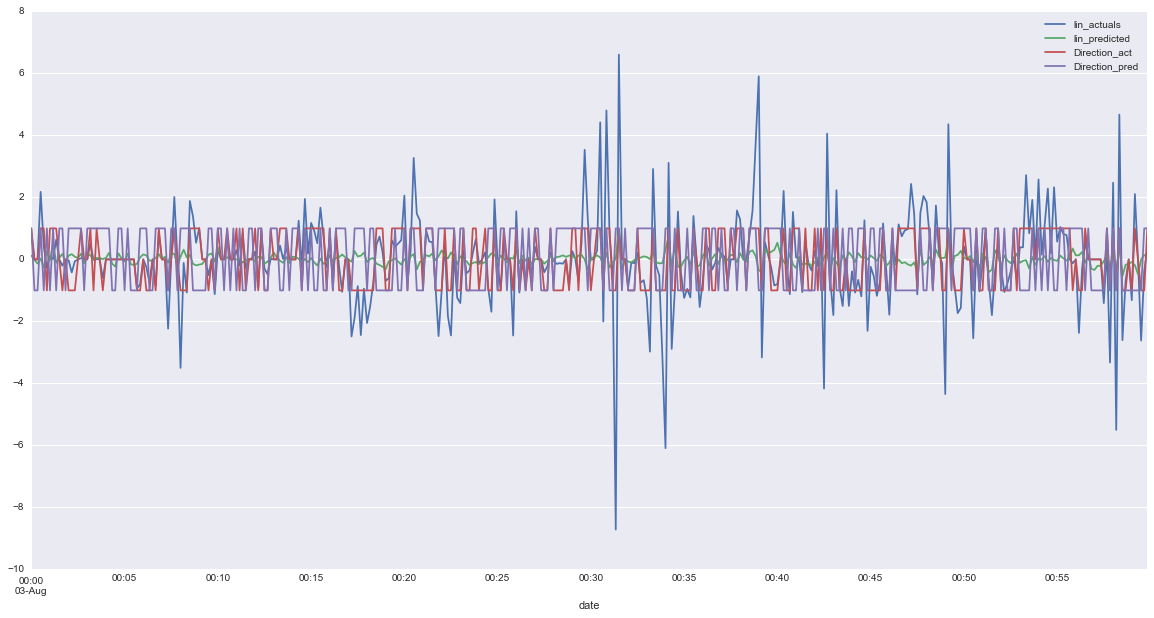

In [35]:
df_reg2class.loc[(df_plot.index.year==2016)&(df_plot.index.month==8)\
            &(df_plot.index.day==3)&(df_plot.index.hour==0)].plot(figsize=(20, 10))

#### Not too good! Better results using the non-differenced data because of the high autocorrelation. There may also be a problem with rounding. Attempts to mitigate this by scaling the data led to failure. Using differences in higher time frames was more promising.

### Classification Methods:

#### First we will try classification methods on the lagged price data. 

In [9]:
y_c = df_lag['Direction'] # for classification
#exog and endog
X = df_lag.drop("Direction", axis = 1)
X = X.drop('price', axis = 1)
y = df_lag['price'] # for regression 


# The test data is split into two parts
start_test = datetime.datetime(2016,6,1)

# Create training and test sets
X_train = X[X.index < start_test]
X_test = X[X.index >= start_test]
y_train = y[y.index < start_test]
y_test = y[y.index >= start_test]
y_c_train = y_c[y_c.index < start_test]
y_c_test = y_c[y_c.index >= start_test]

#### Let's try out several LINEAR different classifation methods and select on cross validated accuracy to further refine the models. Is it a good idea to assume that our time series data is linearly seperable in 360 dimensions? Do some perform better on scaled or unscaled data?? What does scaling have to do with with structure of the data??

In [5]:
sc = StandardScaler()

In [6]:
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

##### Since we are testing so many classifiers, it will be useful to let them run overnight and append them to a list to save later

In [7]:
CV_List = []

#### Perceptron

In [15]:
ppn = Perceptron(n_jobs=3)
scores = cross_validation.cross_val_score(ppn, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "Perceptron CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.7087568   0.7087568   0.15966873  0.70876573  0.70876573]
Perceptron CV accuracy: 0.5989 +/- 0.2196


##### On standardized data:

In [16]:
ppn = Perceptron(n_jobs=3)
scores = cross_validation.cross_val_score(ppn, X_train_std, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "Perceptrion Standardized CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.19679683  0.15966773  0.67452676  0.70874055  0.70905521]
Perceptrion Standardized CV accuracy: 0.4898 +/- 0.2549


#### Logistic Regression

In [17]:
log = LogisticRegression(n_jobs=3)
scores = cross_validation.cross_val_score(log, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores
string =  "Logistic CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.7087568   0.7087568   0.70876126  0.70876573  0.70876573]
Logistic CV accuracy: 0.7088 +/- 0.0000


##### On standardized data:

In [ ]:
log = LogisticRegression(n_jobs=3)
scores = cross_validation.cross_val_score(log, X_train_std, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "Logistic standardized CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

#### Stochastic Gradient Descent Classifier

In [18]:

sgd = SGDClassifier(n_jobs=3)
scores = cross_validation.cross_val_score(sgd, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "SGD CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.1690444   0.7087568   0.70876126  0.70876573  0.13157083]
SGD CV accuracy: 0.4854 +/- 0.2738


##### On standardized data:

In [19]:

sgd = SGDClassifier(n_jobs=3)
scores = cross_validation.cross_val_score(sgd, X_train_std, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "SGD standardized CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.7087568   0.7087568   0.70876126  0.70876573  0.63241726]
SGD standardized CV accuracy: 0.6935 +/- 0.0305


#### KNN (not strictly linear):

In [9]:
knn = KNeighborsClassifier(n_neighbors = 4, n_jobs = 3)
scores = cross_validation.cross_val_score(knn, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "KNN CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.55628835  0.64364243  0.5084013   0.49206119  0.40782742]
KNN CV accuracy: 0.5216 +/- 0.0776


##### On standardized data:

In [10]:
knn = KNeighborsClassifier(n_neighbors = 4, n_jobs = 3)
scores = cross_validation.cross_val_score(knn, X_train_std, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "KNN standardized CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.5564205   0.64345993  0.50847052  0.49211154  0.40779595]
KNN standardized CV accuracy: 0.5217 +/- 0.0775


#### Naive Bayes (not linear but very simple)

In [11]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_validation.cross_val_score(clf, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores
string =  "NB CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.66975237  0.7087568   0.72122791  0.33111395  0.16028017]
NB CV accuracy: 0.5182 +/- 0.2296


##### On standardized data:

In [12]:

clf = GaussianNB()
scores = cross_validation.cross_val_score(clf, X_train_std, y_c_train, cv=5,  scoring ="accuracy")
print scores
string = "NB Standardized CV accuracy: %.4f +/- %.4f" % (np.mean(scores), np.std(scores))
print string
CV_List.append(string)

[ 0.66975237  0.7087568   0.72122791  0.33111395  0.16028017]
NB Standardized CV accuracy: 0.5182 +/- 0.2296


In [21]:
for elem in CV_List:
    print elem

KNN CV accuracy: 0.5216 +/- 0.0776
KNN standardized CV accuracy: 0.5217 +/- 0.0775
NB CV accuracy: 0.5182 +/- 0.2296
NB Standardized CV accuracy: 0.5182 +/- 0.2296
Perceptron CV accuracy: 0.5989 +/- 0.2196
Perceptrion Standardized CV accuracy: 0.4898 +/- 0.2549
Logistic CV accuracy: 0.7088 +/- 0.0000
SGD CV accuracy: 0.4854 +/- 0.2738
SGD standardized CV accuracy: 0.6935 +/- 0.0305


In [23]:
df_cv = pd.DataFrame(CV_List)
df_cv.to_hdf('store_nb.h5', 'cv_list_lin_class')

#### Looks like Logistic and SGD on standardized data performed the best - Logistic on standardized took much too long to converge. 

In [24]:
log = LogisticRegression(n_jobs = 3)
log.fit(X_train, y_c_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=3,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
log_predicted = log.predict(X_test)
log_probas = log.predict_proba(X_test)


In [26]:
confmat = metrics.confusion_matrix(y_true=y_c_test, y_pred=log_predicted)
print confmat

[[     0  91101      0]
 [     0 395116      0]
 [     0 105624      0]]


In [27]:
print metrics.classification_report(y_true=y_c_test, y_pred=log_predicted)

             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00     91101
        0.0       0.67      1.00      0.80    395116
        1.0       0.00      0.00      0.00    105624

avg / total       0.45      0.67      0.53    591841



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
print metrics.accuracy_score(y_true=y_c_test, y_pred=log_predicted)

0.667604981743


#### It looks like the accuracy score was very misleading: both the precision and recall are terrible. This may have to do with the fact that we have so many instances of unchanged prices, or that we have three classes to predict. It also may be that since we actually have something like a 360 dimensional space, separating that space with linear methods is not really feasible.  

In [34]:
sgd = SGDClassifier(n_jobs=3, shuffle=False)
sgd.fit(X_train_std, y_c_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=3,
       penalty='l2', power_t=0.5, random_state=None, shuffle=False,
       verbose=0, warm_start=False)

In [36]:
sgd_predicted = sgd.predict(X_test)


In [37]:
metrics.confusion_matrix(y_true=y_c_test, y_pred=sgd_predicted)

array([[ 91101,      0,      0],
       [395116,      0,      0],
       [105624,      0,      0]])

In [38]:
print metrics.classification_report(y_true=y_c_test, y_pred=sgd_predicted)

             precision    recall  f1-score   support

       -1.0       0.15      1.00      0.27     91101
        0.0       0.00      0.00      0.00    395116
        1.0       0.00      0.00      0.00    105624

avg / total       0.02      0.15      0.04    591841



In [39]:
metrics.accuracy_score(y_true=y_c_test, y_pred=sgd_predicted)

0.15392816651769647

#### Same for the SGD Classifier - it performs poorly on the test data. 

#### Now we will try a scale invariant method - Decision Trees

In [4]:
dtr = DecisionTreeClassifier(max_depth=5)
scores = cross_validation.cross_val_score(dtr, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores

[ 0.64231459  0.7087568   0.70876126  0.60817606  0.66733794]


In [10]:
dtr.fit(X_train, y_c_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [11]:
dtr_predicted = dtr.predict(X_test)
print metrics.classification_report(y_true=y_c_test, y_pred=dtr_predicted)

             precision    recall  f1-score   support

       -1.0       0.28      0.00      0.01     91101
        0.0       0.67      0.04      0.07    395116
        1.0       0.18      0.96      0.30    105624

avg / total       0.53      0.20      0.10    591841



In [5]:
rfr = RandomForestClassifier(n_estimators=5, max_depth=5)
scores = cross_validation.cross_val_score(rfr, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores


[ 0.64587647  0.7087568   0.70876126  0.60828933  0.67613576]


In [12]:
rfr.fit(X_train, y_c_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
rfr_predicted = dtr.predict(X_test)
print metrics.classification_report(y_true=y_c_test, y_pred=rfr_predicted)

             precision    recall  f1-score   support

       -1.0       0.28      0.00      0.01     91101
        0.0       0.67      0.04      0.07    395116
        1.0       0.18      0.96      0.30    105624

avg / total       0.53      0.20      0.10    591841



#### Lets shift to working with the differenced data now, and see if we can get better results, unlike in the linear regression. 

In [14]:
y_c = df_diff['Direction'] # for classification
#exog and endog
X = df_diff.drop("Direction", axis = 1)
X = X.drop('price_delta', axis = 1)
y = df_diff['price_delta'] # for regression 


# The test data is split into two parts
start_test = datetime.datetime(2016,7,1)

# Create training and test sets
X_train = X[X.index < start_test]
X_test = X[X.index >= start_test]
y_train = y[y.index < start_test]
y_test = y[y.index >= start_test]
y_c_train = y_c[y_c.index < start_test]
y_c_test = y_c[y_c.index >= start_test]

In [15]:
dtr = DecisionTreeClassifier(max_depth=5)
scores = cross_validation.cross_val_score(dtr, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores

[ 0.72411208  0.74087167  0.7425502   0.73789402  0.71882681]


In [17]:
dtr.fit(X_train, y_c_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [18]:
dtr_predicted = dtr.predict(X_test)
print metrics.classification_report(y_true=y_c_test, y_pred=dtr_predicted)

             precision    recall  f1-score   support

       -1.0       0.39      0.04      0.08     45934
        0.0       0.80      0.93      0.86    232674
        1.0       0.41      0.45      0.43     54033

avg / total       0.68      0.73      0.68    332641



In [16]:
rfr = RandomForestClassifier(n_estimators=5, max_depth=5)
scores = cross_validation.cross_val_score(rfr, X_train, y_c_train, cv=5,  scoring ="accuracy")
print scores


[ 0.7089326   0.71330281  0.72148673  0.72169894  0.71436164]


In [19]:
rfr.fit(X_train, y_c_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
rfr_predicted = dtr.predict(X_test)
print metrics.classification_report(y_true=y_c_test, y_pred=rfr_predicted)

             precision    recall  f1-score   support

       -1.0       0.39      0.04      0.08     45934
        0.0       0.80      0.93      0.86    232674
        1.0       0.41      0.45      0.43     54033

avg / total       0.68      0.73      0.68    332641



#### The differenced data is much more promising

### It may be that the current classification scheme is not actually all that useful, after all the point is to use this as part of a trading algorithm. What if we binarize with a threshold of around .10 - thus any price movement above ten cents will be 1 in a ten second time period, and anything else will be zero. 

In [43]:
binar = Binarizer(threshold=0.10) 

In [44]:
y_bin_train =(binar.fit_transform(y_train.reshape(-1,1)))
y_bin_test = binar.transform(y_test.reshape(-1,1))

In [38]:
print np.shape(y_bin_train)
print np.shape(X_train)

(1053719, 1)
(1053719, 360)


In [42]:
y_bin_train.reshape(-1)
np.shape(y_bin_train)

(1053719, 1)

In [47]:
dtr = DecisionTreeClassifier(max_depth=10)

In [48]:
dtr.fit(X_train, y_bin_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [49]:
dtr_predicted = dtr.predict(X_test)
print metrics.classification_report(y_true=y_bin_test, y_pred=dtr_predicted)

             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96    307289
        1.0       0.42      0.05      0.09     25352

avg / total       0.89      0.92      0.89    332641



In [50]:
rfr = RandomForestClassifier(n_estimators=20, max_depth=20)

In [51]:
rfr.fit(X_train, y_bin_train)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
rfr_predicted = dtr.predict(X_test)
print metrics.classification_report(y_true=y_bin_test, y_pred=rfr_predicted)

             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96    307289
        1.0       0.42      0.05      0.09     25352

avg / total       0.89      0.92      0.89    332641



#### Better, but there are not enough 1's in the data. It seems like trees will perform much better on 1. more data and 2. data where there are more equal proportions of all classes. This suggest using higher time frame aggregated data over a longer time period. 

### Lets try to plot a 2d decision boundary  of the first two lags to see part of what we are actually dealing with.

In [41]:
X_train = np.array(X_train)

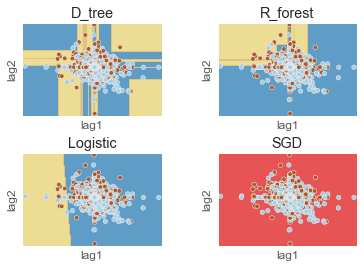

In [56]:
X = X_train[:, :2]  # we only take the first two features. W
                      
y = y_bin_train.ravel()

h = .02  # step size in the mesh


dtr = DecisionTreeClassifier(max_depth=10).fit(X, y)
rfr = RandomForestClassifier(n_estimators=5, max_depth=5).fit(X, y)
log = LogisticRegression(n_jobs = 3).fit(X, y)
sgd = SGDClassifier(n_jobs=3).fit(X, y)


# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['D_tree',
          'R_forest',
          'Logistic',
         'SGD']


for i, clf in enumerate((dtr, rfr, log, sgd)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('lag1')
    plt.ylabel('lag2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

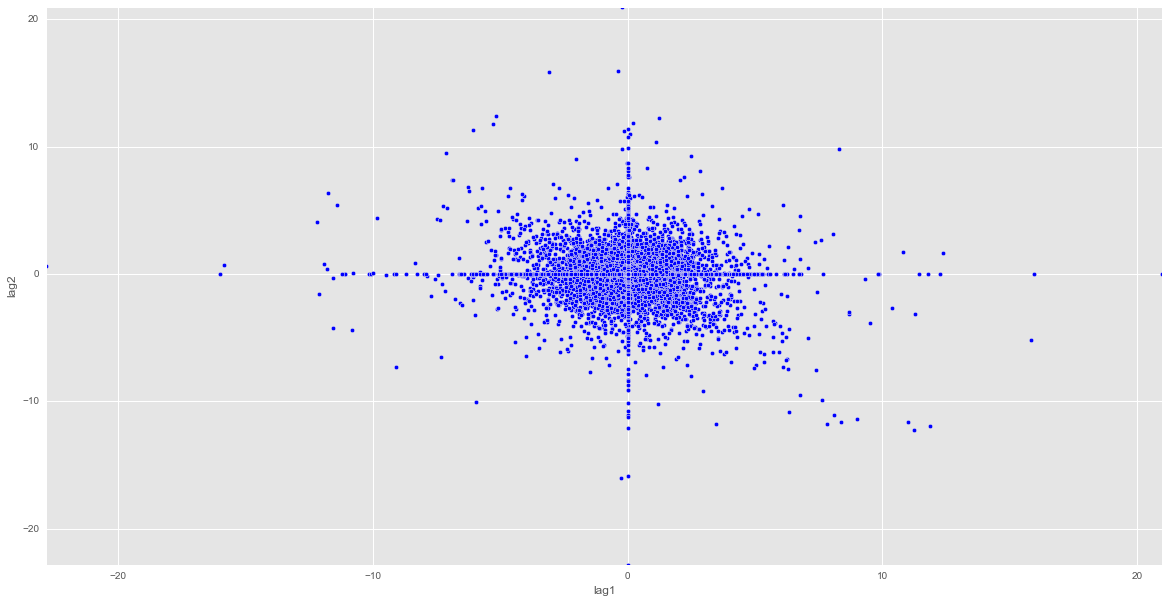

In [57]:
plt.figure(figsize=(20,10))
plt.scatter(X_train[:, 1], X_train[:, 2], c = 'blue', marker = 'o')

plt.xlabel('lag1')
plt.ylabel('lag2')
plt.xlim(X_train[:, 1].min(), X_train[:, 1].max())
plt.ylim(X_train[:, 2].min(),X_train[:, 2].max())


plt.show()

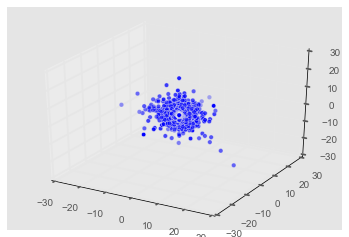

In [59]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 1], X_train[:, 2],X_train[:, 3] , zdir='z', s=20, c='b', depthshade=True)

#### Looks like more work is needed to dermine the optimal organization of the data for classification techniques, and the optimal depth of the tree is probably deeper. Separation looks very hard, even in just three dimensions the data looks like a big ball. Who knows, maybe a structure appears in higher dimensions.